# notebook for troubleshooting and testing solutions for issues in the workflow

Note this is a testing notebook. In this notebook we test different approaches used in our workflow. Mostly these were tested locally, so the paths to data etc will not work.

# tests to find solution for https://github.com/c-scale-community/use-case-hisea/issues/28

In [ ]:

from datetime import timedelta, datetime
from pathlib import Path
import subprocess
import xarray as xr # note dependencies: dask, netCdata4

vars = ('thetao', 'bottomT', 'so', 'zos', 'uo', 'vo')
date_min = '2022-04-01'
date_max = '2022-04-05'

delta = datetime.strptime(date_max, '%Y-%m-%d') - datetime.strptime(date_min, '%Y-%m-%d')

var = vars[0]
i = 0
day = datetime.strptime(date_min, '%Y-%m-%d').date() + timedelta(days=i)
check_file = Path('/Users/backeb/Documents/data/tmp/cmems_'+str(var)+'_'+str(day)+'.nc')

j=0
while not check_file.is_file():
    print('j '+str(i))
    print(check_file.is_file())
    open(check_file, 'a')
    j+=1

print(check_file.is_file())
print(j)

# alternate way to concat netcdata

In [ ]:
from pathlib import Path
import xarray as xr

datasets = []
#for path in Path('/Users/backeb/Documents/data/tmp/').iterdir():
for path in sorted(Path('/Users/backeb/Documents/data/tmp/').rglob('*no3*.nc')):
    print(path)
    ds = xr.open_dataset(path, decode_times=False)
    datasets.append(ds)
combined = xr.concat(datasets, dim='time')

print(combined)

# for download_era5.py get an error when iterating over months
 e.g. from 2021-07-01 to 2022-06-31 the monthstr is empty \
 this is because I'm trying to do `for i in range(7, 6, 1): ...` \
 tests to find a better way to iterate over a period \

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

date_min = '2021-07-01'
date_max = '2022-06-30'

yearstr = []
pdyears = pd.period_range(start=date_min, end=date_max, freq='Y')
[yearstr.append(f'{year:0>4}') for year in pdyears.year]
print(yearstr)

monthstr = []
pdmonths = pd.period_range(start=date_min, end=date_max, freq='M')
#print(np.unique(pdmonths.month))
[monthstr.append(f'{month:0>2}') for month in np.unique(pdmonths.month)]
print(monthstr)

daystr = []
pddays = pd.period_range(start=date_min, end=date_max, freq='D')
#print(np.unique(pddays.day))
[daystr.append(f'{day:0>2}') for day in np.unique(pddays.day)]
print(daystr)



# tests to change download_era5.py to deal with CDS API limitation: https://github.com/c-scale-community/use-case-hisea/issues/30


In [ ]:
from datetime import timedelta, datetime

date_min = '2021-07-01'
date_max = '2022-06-30'
vars = ('10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure', '2m_dewpoint_temperature', 'relative_humidity', 'surface_net_solar_radiation', '2m_temperature', 'total_cloud_cover')

vars = list(vars)
print(vars)

delta = datetime.strptime(date_max, '%Y-%m-%d') - datetime.strptime(date_min, '%Y-%m-%d')
i = 0
day = datetime.strptime(date_min, '%Y-%m-%d').date() + timedelta(days=i)
yearstr = [f'{day.year:0>4}']
print(yearstr)
monthstr = [f'{day.month:0>2}']
print(monthstr)
daystr = [f'{day.day:0>2}']
print(daystr)



# tests to figure out https://github.com/c-scale-community/use-case-hisea/issues/3

In [ ]:
from datetime import timedelta, datetime
from pathlib import Path
import subprocess
import xarray as xr

username = 'insert'
password = 'insert'
longitude_min = 22.5
longitude_max = 24.5
latitude_min = 36.5
latitude_max = 38.5
date_min = '2022-04-01'
date_max = '2022-04-02'
vars = ('thetao', 'bottomT', 'so', 'zos', 'uo', 'vo')

#make the /data/tmp directory if it does not exist
Path('/data/tmp').mkdir(parents=True, exist_ok=True)
delta = datetime.strptime(date_max, '%Y-%m-%d') - datetime.strptime(date_min, '%Y-%m-%d')
for var in vars:
        for i in range(delta.days+1):
                max_runs = 2
                run = 0
                day = datetime.strptime(date_min, '%Y-%m-%d').date() + timedelta(days=i)
                check_file = Path('/data/tmp/cmems_'+str(var)+'_'+str(day)+'.nc')
                while not check_file.is_file() and run < max_runs:
                        try:
                                subprocess.run(['python', '-m', 'motuclient',
                                        '--motu', 'https://nrt.cmems-du.eu/motu-web/Motu',
                                        '--service-id', 'GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS',
                                        '--product-id', 'global-analysis-forecast-phy-001-024',
                                        '--longitude-min',str(longitude_min),
                                        '--longitude-max', str(longitude_max),
                                        '--latitude-min', str(latitude_min),
                                        '--latitude-max', str(latitude_max),
                                        '--date-min', str(day)+' 12:00:00',
                                        '--date-max', str(day)+' 12:00:00',
                                        '--depth-min', '0.493',
                                        '--depth-max', '5727.918000000001',
                                        '--variable', str(var),
                                        '--out-dir', '/data/tmp',
                                        '--out-name', 'cmems_'+str(var)+'_'+str(day)+'.nc',
                                        '--user', username,
                                        '--pwd', password],
                                        check=True,
                                        timeout=300)
                        except subprocess.TimeoutExpired as e:
                                print(var)
                                print(e.stdout)
                                print(e.stderr)
                                continue
                        else:
                                break
                        finally:
                                run += 1
        ds = xr.open_mfdataset('/data/tmp/cmems_'+var+'_*.nc')
        ds.to_netcdata('/data/cmems_'+var+'.nc')

# temporary workaround to update RadSurf_daily.tim: https://github.com/c-scale-community/use-case-hisea/issues/43#issuecomment-1463896339


In [ ]:
import pandas as pd
pname = '../fm_model/input/'
fname = 'RadSurf_daily.tim'

data = pd.read_csv(pname+fname, delim_whitespace=True, header=None)#, names=["Time", "Value"])
import matplotlib.pyplot as plt

# Plot the first 730 points
plt.plot(data.iloc[:730, 0], data.iloc[:730, 1])

# Overlay the next 730 points, and so on
for i in range(730, len(data), 730):
    plt.plot(data.iloc[i:i+730, 0], data.iloc[i:i+730, 1])
    
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()



print(data)

In [ ]:
# Plot the last 100 data points as different coloured dots
plt.scatter(data.iloc[-730:, 0], data.iloc[-730:, 1])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
# Define the reference time
tref = pd.to_datetime('2015-01-01')

# Add a datetime column based on the first column
data['datetime'] = pd.to_datetime(tref) + pd.to_timedelta(data.iloc[:, 0], unit='m')

# Print the updated dataframe
print(data)


In [ ]:
import warnings

# Filter out future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Your code here

# Reset warning filters
warnings.resetwarnings()

# Append an empty row
data = data.append({}, ignore_index=True)

print(data)

In [ ]:
# Get the previous value in column 0
prev_value = data.iloc[-2, 0]

# Get the unique difference between all the values in column 0
unique_diff = data[0].diff().dropna().unique()
print(unique_diff)

# Fill the value in column 0, row 2920 with the previous value plus the unique difference
data.iloc[-1, 0] = prev_value + unique_diff.sum()

print(data)

In [ ]:
# Set datetime of last row to the corresponding value in column 0
data.iloc[-1, 2] = pd.to_datetime('2015-01-01') + pd.to_timedelta(data.iloc[-1, 0], unit='m')

print(data)

In [ ]:
# Get the day and month of the datetime in the last row
last_date = data.iloc[-1]['datetime']
last_day_month = last_date.strftime('%m-%d')

# Create a mask to filter the rows with the same day and month
mask = data['datetime'].dt.strftime('%m-%d') == last_day_month

# Compute the average of values in column 1 for these rows
# Set the value in the last row of column 1 as the average
data.iloc[-1, 1] = data.loc[mask, 1].mean()

print(data)


In [ ]:
# Plot the last 100 data points as different coloured dots
plt.scatter(data.iloc[-730:, 0], data.iloc[-730:, 1], c=range(730), cmap='viridis')

# Plot the last value as a red dot
plt.scatter(data.iloc[-1, 0], data.iloc[-1, 1], color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### final solution

In [139]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pname = '../fm_model/input/'
fname = 'RadSurf_daily.tim'

data = pd.read_csv(pname+fname, delim_whitespace=True, header=None)#, names=["Time", "Value"])

# Define the reference time
tref = pd.to_datetime('2015-01-01')
#print(tref, '\n')

# Add a datetime column based on the first column
data['datetime'] = pd.to_datetime(tref) + pd.to_timedelta(data.iloc[:, 0], unit='m')

# get the number of days between the last datetime in the last row and date_max
date_max = pd.to_datetime('2023-03-11')
last_datetime = data.iloc[-1]['datetime']
days_diff = int((date_max - last_datetime) / pd.Timedelta(days=1))
#print(days_diff, '\n')


for i in range(days_diff+1):

    # Append an empty row
    data = data.append({}, ignore_index=True)

    # Get the previous value in column 0
    prev_value = data.iloc[-2, 0]
    #print(prev_value, '\n')

    # Get the unique difference between all the values in column 0
    unique_diff = data[0].diff().dropna().unique()
    #print(unique_diff, '\n')

    # Fill the value in column 0, last row with the previous value plus the unique differenc
    data.iloc[-1, 0] = prev_value + unique_diff

    # Set datetime of last row to the corresponding value from column 0
    data.iloc[-1, 2] = pd.to_datetime('2015-01-01') + pd.to_timedelta(data.iloc[-1, 0], unit='m')

    # Get the day and month of the datetime in the last row
    last_date = data.iloc[-1]['datetime']
    last_day_month = last_date.strftime('%m-%d')
    #print(last_date)
    #print(last_day_month)

    # Create a mask to filter the rows with the same day and month
    mask = data['datetime'].dt.strftime('%m-%d') == last_day_month

    # Compute the average of values in column 1 for these rows
    # Set the value in the last row of column 1 as the average
    data.iloc[-1, 1] = data.loc[mask, 1].mean()

# convert column 0 to integers
data[0] = data[0].astype(int)

# write to file
data.to_csv('output.txt', columns=[0,1], header=False, index=False, sep='\t')

#print(data)
    

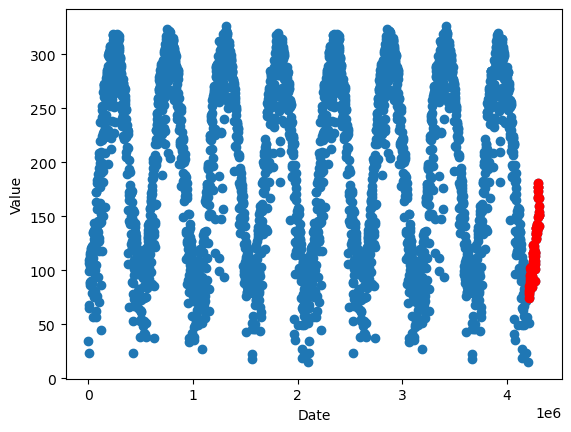

            0           1            datetime
0         720   34.891102 2015-01-01 12:00:00
1        2160   64.832245 2015-01-02 12:00:00
2        3600   99.305632 2015-01-03 12:00:00
3        5040   68.144176 2015-01-04 12:00:00
4        6480   23.697907 2015-01-05 12:00:00
...       ...         ...                 ...
2987  4302000  153.744316 2023-03-07 12:00:00
2988  4303440  140.642976 2023-03-08 12:00:00
2989  4304880  150.927549 2023-03-09 12:00:00
2990  4306320  159.185942 2023-03-10 12:00:00
2991  4307760  151.250944 2023-03-11 12:00:00

[2992 rows x 3 columns]


In [144]:
# Plot the last 730 data points 
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])

# Plot the last value as a red dot
plt.scatter(data.iloc[-days_diff:, 0], data.iloc[-days_diff:, 1], color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

print(data)

### click comand line interface for final solution

In [ ]:
import pandas as pd
import click


@click.command()
@click.argument('date_max', type=str)
@click.argument('filename_in', type=str)
@click.argument('filename_out', type=str)
def main(date_max, filename_in, filename_out):
    # Define the reference time
    tref = pd.to_datetime('2015-01-01')

    # Read in the input data
    data = pd.read_csv(filename_in, delim_whitespace=True, header=None)

    # Add a datetime column based on the first column
    data['datetime'] = pd.to_datetime(tref) + pd.to_timedelta(data.iloc[:, 0], unit='m')

    # get the number of days between the last datetime in the last row and date_max
    date_max = pd.to_datetime(date_max)
    last_datetime = data.iloc[-1]['datetime']
    days_diff = int((date_max - last_datetime) / pd.Timedelta(days=1))

    for i in range(days_diff+1):
        # Append an empty row
        data = data.append({}, ignore_index=True)

        # Get the previous value in column 0
        prev_value = data.iloc[-2, 0]

        # Get the unique difference between all the values in column 0
        unique_diff = data[0].diff().dropna().unique()

        # Fill the value in column 0, last row with the previous value plus the unique difference
        data.iloc[-1, 0] = prev_value + unique_diff

        # Set datetime of last row to the corresponding value from column 0
        data.iloc[-1, 2] = pd.to_datetime('2015-01-01') + pd.to_timedelta(data.iloc[-1, 0], unit='m')

        # Get the day and month of the datetime in the last row
        last_date = data.iloc[-1]['datetime']
        last_day_month = last_date.strftime('%m-%d')

        # Create a mask to filter the rows with the same day and month
        mask = data['datetime'].dt.strftime('%m-%d') == last_day_month

        # Compute the average of values in column 1 for these rows
        # Set the value in the last row of column 1 as the average
        data.iloc[-1, 1] = data.loc[mask, 1].mean()

    # convert column 0 to integers
    data[0] = data[0].astype(int)

    # write to file
    data.to_csv(filename_out, columns=[0, 1], header=False, index=False, sep='\t')


if __name__ == '__main__':
    main()

# To run this code, you would use the following command in the terminal
#
#     python myscript.py 2023-03-11 input.txt output.txt
#
# where myscript.py is the name of your Python script file. 
# You would need to replace 2023-03-11 with the desired date_max, 
# input.txt with the name of your input file, and output.txt with 
# the desired name for your output file.


